In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os 
os.chdir("/content/drive/My Drive/299Project/Mask_RCNN/")

In [ ]:
#!pip3 install --upgrade tensorflow==2.2.0


#!mkdir mahir
# !rm -r mahir

In [ ]:
import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
#from twilio.rest import Client

In [ ]:
class MaskRCNNConfig(mrcnn.config.Config):
  NAME = "coco_pretrained_model_config"
  IMAGES_PER_GPU = 1
  GPU_COUNT = 1
  NUM_CLASSES = 80 + 1
  DETECTION_MIN_CONFIDENCE = 0.6

In [ ]:
#drive.flush_and_unmount()
#!sudo apt-get install cuda
!nvidia-smi

Mon May 24 12:13:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from pathlib import Path
#twilio_acc_sid = 'AC33d9260bbdd5e04044373b2430493afe'
#twilio_auth = 'c633d9876c757ba22a8d7e45a086c4a5'
#twilio_phone_number = '+12024996633'
#twilio_destination_number = '+8801737948136'
#client = Client(twilio_acc_sid, twilio_auth)

ROOT_DIR = Path(".")


MODEL_DIR = os.path.join(ROOT_DIR, "logs")
coco_model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


model = MaskRCNN(mode = 'inference', model_dir=MODEL_DIR, config = MaskRCNNConfig())
model.load_weights(coco_model_path, by_name =True)

Video_source = "test_images/video.mp4"

video_capture = cv2.VideoCapture(Video_source)

Instructions for updating:
Use fn_output_signature instead


Current frame counter0


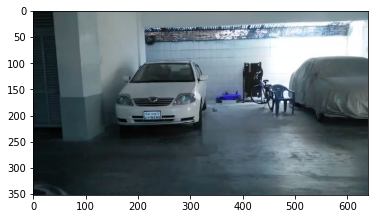

Current frame counter5


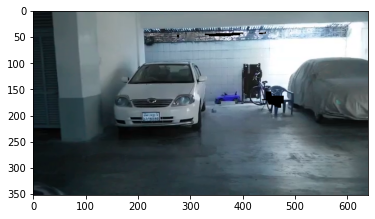

Current frame counter10


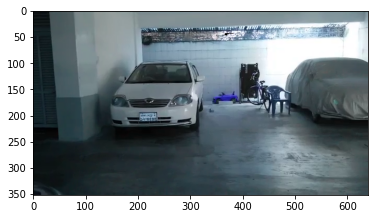

Current frame counter15


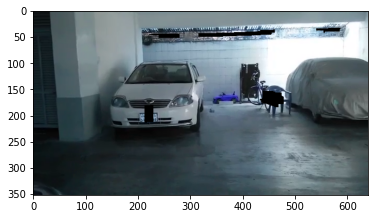

Current frame counter20


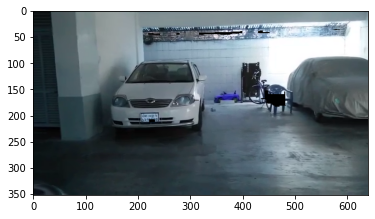

Current frame counter25


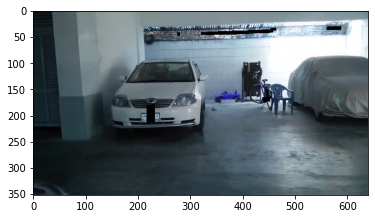

Current frame counter30


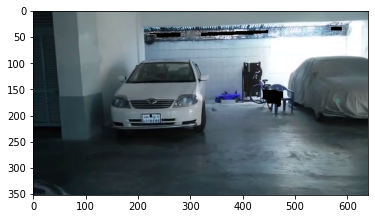

Current frame counter35


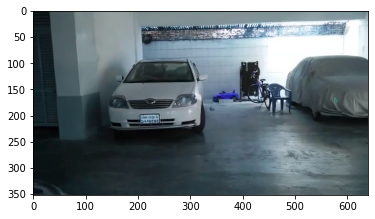

Current frame counter40


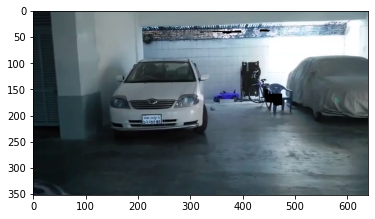

Current frame counter45


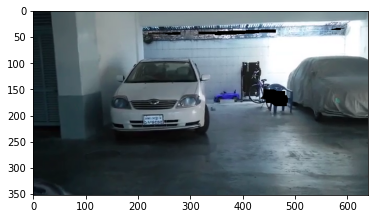

Current frame counter50


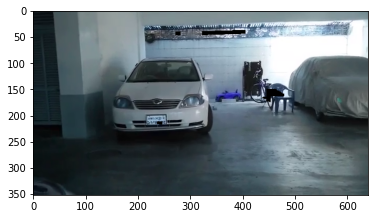

Current frame counter55


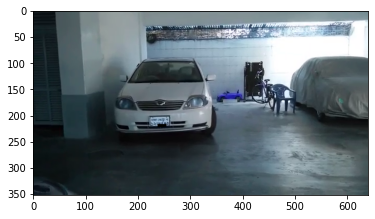

going in to mark vehicles. Frame number:   60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processing Done. End of Video.


In [ ]:
import matplotlib as plt



count = 0
parked_car_boxes = None
car_boxes = None
free_space = False
#sms_sent = False

# Filter to only cars
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # class id: 3 for car, 8 for truck, 6 for bus
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)



#main loop
while video_capture.isOpened():
    success, frame = video_capture.read()

    if not success:
      print("Processing Done. End of Video.")
      break
    elif count<60:
      #create another video reader object to compare the two frames and verify the possibility of motion
      success, frame2 = video_capture.read()
      d = cv2.absdiff(frame, frame2)  
      grey = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(grey, (1, 1), 0)
      ret, th = cv2.threshold( blur, 20, 255, cv2.THRESH_BINARY)
      
      #perform these morphological transformations to erode the car which is moving so that it is not detected by MASKRCNN. Take the eorsion levels to be high. 
      dilated = cv2.dilate(th, np.ones((10, 10), np.uint8), iterations=1 )
      eroded = cv2.erode(dilated, np.ones((30, 30), np.uint8), iterations=1 )
        
      #fill the contours for even a better morphing of the vehicle
      c, h = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      frame2 = cv2.drawContours(frame2, c, -1, (0,0,0), cv2.FILLED)

      if count%5 == 0:
        print("Current frame counter" + str(count))
        plt.pyplot.imshow(frame2)
        plt.pyplot.show()
      
      count = count + 1
      continue

  # GBR to RGB
    rgb_image = frame[:, :, ::-1]
    
    

    # The r variable will now have the results of detection:
    # - r['rois'] are the bounding box of each detected object
    # - r['class_ids'] are the class id (type) of each detected object
    # - r['scores'] are the confidence scores for each detection
    # - r['masks'] are the object masks for each detected object (which gives you the object outline)
    if parked_car_boxes is None:
        print("going in to mark vehicles. Frame number:  ", count)
        # This is the first frame of video - assume all the cars detected are in parking spaces.
        # Save the location of each car as a parking space box and go to the next frame of video.
        results = model.detect([rgb_image], verbose=0)
        r = results[0]
        parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])
          
    elif len(parked_car_boxes)!= 0:
        results = model.detect([rgb_image], verbose=0)
        r = results[0]
        # Get where cars are currently located in the frame
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # See how much those cars overlap with the known parking spaces
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

        

        # Loop through each known parking space box
        for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):

            # For this parking space, find the max amount it was covered by any
            # car that was detected in our image (doesn't really matter which car)
            max_IoU_overlap = np.max(overlap_areas)

            # Get the top-left and bottom-right coordinates of the parking area
            y1, x1, y2, x2 = parking_area

            # Check if the parking space is occupied by seeing if any car overlaps
            # it by more than 0.15 using IoU
            if max_IoU_overlap < 0.15:
                # Parking space not occupied! Draw a green box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                # Flag that we have seen at least one open space
                free_space = True
            else:
                # Parking space is still occupied - draw a red box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

            # Write the IoU measurement inside the box
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.7, (255, 255, 255))

        # If at least one space was free, start counting frames
        # This is so we don't alert based on one frame of a spot being open.
        # This helps prevent the script triggered on one bad detection.
        """
        if free_space:
            free_space_frames += 1
        else:
            # If no spots are free, reset the count
            free_space_frames = 0
        """
      # If a space has been free for several frames, we are pretty sure it is really free!
    """
        if free_space:
            # Write SPACE AVAILABLE!! at the top of the screen
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"SPACE AVAILABLE!", (10, 150), font, 3.0, (0, 255, 0), 2, cv2.FILLED)
            
            # If we haven't sent an SMS yet, sent it!
            if not sms_sent:
                print("SENDING SMS!!!")
                message = client.messages.create(
                    body="Parking space available!!!",
                    from_=twilio_phone_number,
                    to=destination_phone_number
                )
                sms_sent = True
                print("Hope you got the message on your phone")
    """
   # Show the frame of video on the screen
   # cv2.imshow('Video', frame)
   #saving each frame
    name = str(count) + ".jpg"
    name = os.path.join('./predicted', name)
    cv2.imwrite(name, frame)
    count+=1


video_capture.release()


In [ ]:
#create video including all the frames in the mahir folder
import glob

images = list(glob.iglob(os.path.join('./predicted', '*.*')))
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

# Get all image file paths to a list.
# Sort the images by name index.
# images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

def make_video(outvid, images=None, fps=30, size=None, is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid
  
make_video('./FinalVideo.mp4', images, fps=30)

<VideoWriter 0x7f92ec7bfb70>